In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### import all library

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.util import img_as_float64
#from skimage import data, color
from skimage.transform import  resize
from skimage.color import rgb2gray

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

### All Constant

In [ ]:
K = 200     #no of. segment
m = 10      #compactness[1,40]
sqr = 10    #10*10 pixel around each center
rgb2yuv = np.array([[0.299, 0.587, 0.114],
                 [-0.14713, -0.28886, 0.436],
                 [0.615, -0.51499, -0.10001]]).T

yuv2rgb = np.array([[1, 0, 1.13983],
                 [1, -0.39465, -.58060],
                 [1, 2.03211, 0]]).T

### image read

In [ ]:
def read_image(path):
    imr=imread(path)
    #print(imr.shape)
    newsize = (300, 400)
    image_resized = resize(imr, (newsize),anti_aliasing=True)
    #print(image_resized.shape)
    img = img_as_float64(image_resized)
    #plt.imshow(img)
    return img

(600, 800, 3)
3


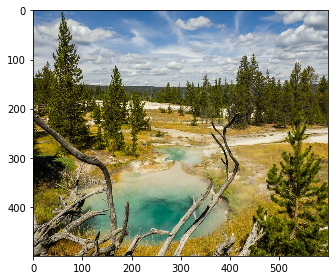

In [ ]:
#resize image:

im = imread(r"/content/drive/My Drive/Colab Notebooks/Image Colorization/Training/100.jpg")  
print(im.shape)
newsize = (500, 600) 
image_resized = resize(im, (newsize),anti_aliasing=True)
print(len(image_resized.shape))
imshow(image_resized)

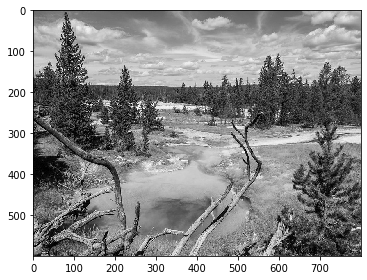

In [ ]:
#gray image convert
ime = imread('/content/drive/My Drive/Colab Notebooks/Image Colorization/Training/100.jpg')
gray=rgb2gray(ime)
imshow(gray,  cmap=plt.cm.gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


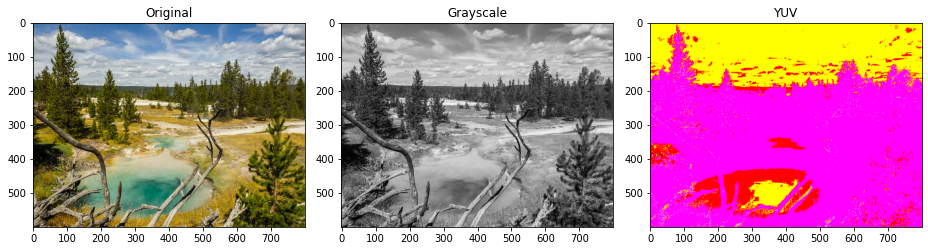

In [ ]:
im=imread(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/Training/100.jpg')
gray=rgb2gray(im)
yuvtest = np.dot(im,rgb2yuv)
fig, axes = plt.subplots(1, 3, figsize=(13, 7))
ax = axes.ravel()

ax[0].imshow(im)
ax[0].set_title("Original")
ax[1].imshow(gray,  cmap=plt.cm.gray)
ax[1].set_title("Grayscale")
ax[2].imshow(yuvtest)
ax[2].set_title("YUV")

fig.tight_layout()

### Segmentation

In [ ]:
def SLIC_superpixel(img,K,m):
    seg = slic(img, K, m, sigma=1)
    return seg

Slic number of segments: 132


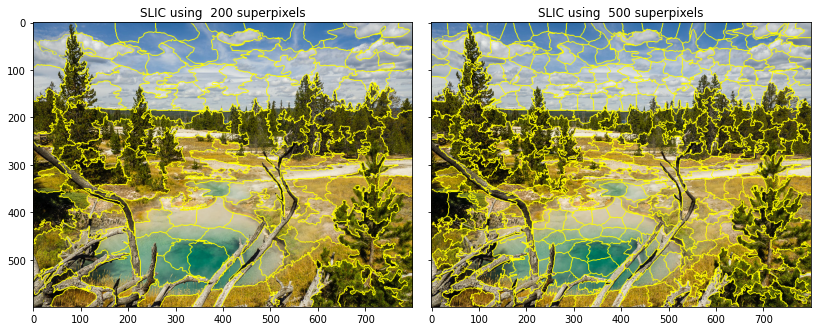

In [ ]:
img = imread(r'/content/drive/My Drive/Colab Notebooks/Image Colorization/Training/100.jpg')

seg = SLIC_superpixel(img,K,m)
seg2 = SLIC_superpixel(img,500,m)

print("Slic number of segments: %d" % len(np.unique(seg)))

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw={'adjustable':'box'})
fig.set_size_inches(12, 6, forward=True)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.05, 0.05) #(left,right,bottom,top,hspace,wshape)

ax[0].imshow(mark_boundaries(img, seg))
ax[0].set_title("SLIC using  200 superpixels")

ax[1].imshow(mark_boundaries(img, seg2))
ax[1].set_title("SLIC using  500 superpixels")

plt.show()

In [ ]:
img = read_image('/content/drive/My Drive/Colab Notebooks/Image Colorization/Training/100.jpg')
seg = SLIC_superpixel(img,K,m)
yuv = np.dot(img,rgb2yuv) #convert YUV color space. Where, U and V are the chrominance
                          #luminance is denoted by Y
mx_seg = seg.max() + 1

total_point = np.zeros(mx_seg)
center = np.zeros((mx_seg, 2))
Y = np.zeros(mx_seg)
U = np.zeros(mx_seg)
V = np.zeros(mx_seg)
#print(mx_seg)

for (i,j), val in np.ndenumerate(seg):
    #print(i,j,value)
    total_point[val] += 1
    center[val][0] += i
    center[val][1] += j
    Y[val] += yuv[i][j][0]
    U[val] += yuv[i][j][1]
    V[val] += yuv[i][j][2]

for i in range(mx_seg):
    center[i] /= total_point[i]
    Y[i] /= total_point[i]
    U[i] /= total_point[i]
    V[i] /= total_point[i]
#print(center)

feature_1 = yuv
for (i,j),val in np.ndenumerate(seg):
    feature_1[i][j][0] = Y[val]
    feature_1[i][j][1] = U[val]
    feature_1[i][j][2] = V[val]
#imshow(feature_1)

feature_1 = img_as_float64(feature_1)
feature_2 = feature_1
mx1,mx2 = 0,0
eta = 20
for (i,j),val in np.ndenumerate(feature_1[:,:0]):
  for j in range(600):
    v,v2,v3,point=0.0,0.0,0.0
    for x in range(eta):
      if(x+i>=500):
        break;
      for y in range(eta):
        if(y+j>=600):
          break;
        v = v + feature_1[i+x][j+y][0]
        v2 = v2 + feature_1[i+x][j+y][1]
        v3 = v3 + feature_1[i+x][j+y][2]
        point = point+1.0
    feature_2[i][j][0] = v/point
    feature_2[i][j][1] = v2/point
    feature_2[i][j][2] = v3/point
#imshow(feature_2)

feature_1 = np.dot(feature_1,yuv2rgb)
feature_2 = np.dot(feature_2,yuv2rgb)

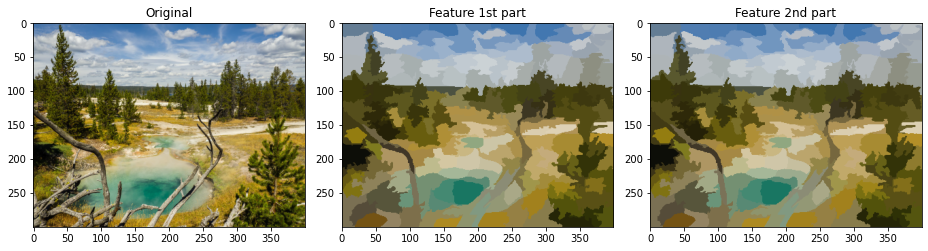

In [ ]:
#yuvtest = np.dot(im,rgb2yuv)
fig, axes = plt.subplots(1, 3, figsize=(13, 7))
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title("Original")
ax[1].imshow(feature_1)
ax[1].set_title("Feature 1st part")
ax[2].imshow(feature_2)
ax[2].set_title("Feature 2nd part")
fig.tight_layout()

### Training

In [ ]:
def feature_Extract(img,seg):
    yuv = np.dot(img,rgb2yuv) #convert YUV color space. Where, U and V are the chrominance
                              #luminance is denoted by Y
    mx_seg = seg.max() + 1

    total_point = np.zeros(mx_seg)
    center = np.zeros((mx_seg, 2))
    Y = np.zeros(mx_seg)
    U = np.zeros(mx_seg)
    V = np.zeros(mx_seg)
    #print(mx_seg)

    for (i,j), val in np.ndenumerate(seg):
        #print(i,j,value)
        total_point[val] += 1
        center[val][0] += i
        center[val][1] += j
        #Y[val] += yuv[i][j][0]
        U[val] += yuv[i][j][1]
        V[val] += yuv[i][j][2]

    for i in range(mx_seg):
        center[i] /= total_point[i]
        #Y[i] /= total_point[i]
        U[i] /= total_point[i]
        V[i] /= total_point[i]
    #print(center)

    feature_1 = yuv
    for (i,j),val in np.ndenumerate(seg):
        #feature_1[i][j][0] = Y[val]
        feature_1[i][j][1] = U[val]
        feature_1[i][j][2] = V[val]
    #imshow(feature_1)

    feature_1 = img_as_float64(feature_1)
    feature_2 = feature_1
    mx1,mx2 = 0,0
    eta = 20
    for (i,j),val in np.ndenumerate(feature_1[:,:0]):
      for j in range(600):
        v,v2,v3,point=0.0,0.0,0.0
        for x in range(eta):
          if(x+i>=500):
            break;
          for y in range(eta):
            if(y+j>=600):
              break;
            #v = v + feature_1[i+x][j+y][0]
            v2 = v2 + feature_1[i+x][j+y][1]
            v3 = v3 + feature_1[i+x][j+y][2]
            point = point+1.0
        #feature_2[i][j][0] = v/point
        feature_2[i][j][1] = v2/point
        feature_2[i][j][2] = v3/point
    #imshow(feature_2)

    feature = np.zeros((mx_seg, (sqr)**2))
    #print(feature)

    R = img.shape[0]
    C = img.shape[1]
    for k in range(mx_seg):
        row = int(center[k][0])
        col = int(center[k][1])
        for i in range(0, sqr):
            if(i+row>=R):
                break
            for j in range(0, sqr):
                if(j+col>=C):
                  break;
                feature[k][i*sqr + j] = feature_2[i + row][j + col][0]
    #feature = np.reshape(feature, (mx_seg*100))
    return feature,U,V

In [ ]:
directory=r'/content/drive/My Drive/Colab Notebooks/Image Colorization/Training'
list=os.listdir(directory)
print(r'Trainnig/'+str(list[1])+'')

Trainnig/2.jpg


In [ ]:
directory=r'/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset'     
list=os.listdir(directory)

X = np.array([]).reshape(0, sqr**2)
U_L = np.array([])
V_L = np.array([])
total_data = 0
for path in list:
    if (total_data>800):
      break
    path = r'/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/'+path+''
    print(path)
    img = read_image(path)
    n = len(img.shape)
    if(n<3):
      continue
    total_data = total_data + 1

    print(total_data)
    seg = SLIC_superpixel(img,K,m)
    feature,U,V = feature_Extract(img,seg)
    #print(feature.shape)
    X = np.concatenate((X, feature), axis=0)
    #print(X.shape)
    U_L = np.concatenate((U_L, U), axis=0)
    V_L = np.concatenate((V_L, V), axis=0)


/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1618).jpg
1
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1668).jpg
2
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1720).jpg
3
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1676).jpg
4
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1729).jpg
5
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1677).jpg
6
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1619).jpg
7
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1594).jpg
8
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1673).jpg
9
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1602).jpg
10
/content/drive/My Drive/Colab Notebooks/Image Colorization/Train_dataset/(1620).jpg
11
/content/drive/My Drive/Colab Notebooks/Image Colori

In [ ]:
u_svr = SVR()
v_svr = SVR()

u_svr.fit(X, U_L)
v_svr.fit(X, V_L)

In [ ]:
import joblib
filename = '/content/drive/My Drive/Colab Notebooks/Image Colorization/u_SVR_800_data.sav'
joblib.dump(u_svr, filename)

filename2 = '/content/drive/My Drive/Colab Notebooks/Image Colorization/v_SVR_800_data.sav'
joblib.dump(v_svr, filename2)
print('saved')

loaded_model = joblib.load(filename)

In [ ]:
print(X.shape)
print(U_L.shape)
print(V_L.shape)

In [ ]:
print(u_LR)
print(v_LR)

In [ ]:
print(feature.shape)
print(U.shape)
print(V.shape)


In [ ]:
#If no. of channel is equal to 1 what happend in segmentation
img = read_image('/content/drive/My Drive/Colab Notebooks/Image Colorization/Test/test_1.jpg')
gray_img = rgb2gray(img)
#seg = SLIC_superpixel(gray_img,K,m)
seg = slic(img, K, m, sigma=1,multichannel='False',convert2lab='False')


print("Slic number of segments: %d" % len(np.unique(seg)))
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw={'adjustable':'box'})
fig.set_size_inches(12, 6, forward=True)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.05, 0.05)

ax[0].imshow(mark_boundaries(gray_img, seg))
ax[0].set_title("SLIC using  200 superpixels")

ax[1].imshow(gray_img,cmap=plt.cm.gray)
ax[1].set_title("Gray Image")

plt.show()


In [ ]:
#If no. of channel is equal to 3 what happend in segmentation
img = read_image('/content/drive/My Drive/Colab Notebooks/Image Colorization/Test/test_1.jpg')
gray_img = rgb2gray(img)

channel_3_img = np.zeros_like(img)
channel_3_img[:,:,0] = gray_img
channel_3_img[:,:,1] = gray_img
channel_3_img[:,:,2] = gray_img

seg = SLIC_superpixel(channel_3_img,K,m)

print("Slic number of segments: %d" % len(np.unique(seg)))
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw={'adjustable':'box'})
fig.set_size_inches(12, 6, forward=True)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.05, 0.05)

ax[0].imshow(mark_boundaries(gray_img, seg))
ax[0].set_title("SLIC using  200 superpixels")

ax[1].imshow(channel_3_img)
ax[1].set_title("Gray Image")

plt.show()


### Test Image

In [ ]:
def testRun(directory):
    img = read_image(directory)
    
    print(img.shape)
    gray_img = rgb2gray(img)
    print(gray_img.shape)
    channel_3_img = np.zeros_like(img)
    channel_3_img[:,:,0] = gray_img
    channel_3_img[:,:,1] = gray_img
    channel_3_img[:,:,2] = gray_img

    seg = SLIC_superpixel(channel_3_img,K,m)

    feature,U,V = feature_Extract(channel_3_img,seg)
    yuv = np.dot(channel_3_img,rgb2yuv)
    #Predict using SVR
    predict_u = u_svr.predict(feature)
    predict_v = v_svr.predict(feature)

    # Reconstruct images
    for (i,j), val in np.ndenumerate(seg):
        yuv[i][j][1] = predict_u[val]
        yuv[i][j][2] = predict_v[val]
    rgb = np.dot(yuv, yuv2rgb)
    return rgb,img